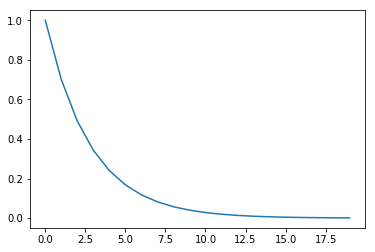

In [43]:
import os
import soundfile  as sf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from util import audio,my_util
import copy as cp
import scipy
from scipy.signal import find_peaks
import IPython.display as ipd
import pyworld as pw

frame_period = 10

_NFFT_ = 8192
fs = 44100
HOP_LEN = int(44100/(1000/frame_period))
freq_range = 1000

# use for smooth envelope's tail
fade_len = 20
fade_kernel =0.7**np.arange(20)
mirror_N =  50
def plot_power_spec(x,title='Fig',nfft=_NFFT_):
    k = np.arange(nfft)
    T = _NFFT_/fs
    frq = k/T # two sides frequency range
    plt.xlabel('Hz')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.plot(frq[:len(x)],x,'r')
    plt.show()
def getAmpPha(x):
    X = librosa.stft(x,n_fft=_NFFT_,win_length = 8192, hop_length=HOP_LEN)
    absX = np.abs(X)
    phaX = X/absX
    return absX,phaX
def get_peak_idx(seg_A,seg_B,distA=20,distB=20):
    # solve overshot by spectrum flipping
#     seg_A = np.concatenate((seg_A[:mirror_N][::-1],seg_A))
#     seg_B = np.concatenate((seg_B[:mirror_N][::-1],seg_B))
#     seg_A[0] = max(seg_A)
#     seg_B[0] = max(seg_B)
    
    peaks_A, _ = find_peaks(seg_A, distance=distA)
    
    #distance=distA: this is not bug, let peaks_B follow A's pitch have better result
    peaks_B, _ = find_peaks(seg_B, distance=distA)
    
    return peaks_A,peaks_B
def getCurveLog(seg_A,seg_B,peaks_A,peaks_B):



    #insert(_,where,value,_)
#     peaks_A =  np.insert(peaks_A, 0, 0, axis=0)
#     peaks_B =  np.insert(peaks_B, 0, 0, axis=0)

    
#     c1 = scipy.interpolate.BSpline(peaks_A,seg_A[peaks_A],2)(range(freq_range))
#     c2 = scipy.interpolate.BSpline(peaks_B,seg_B[peaks_B],2)(range(freq_range))
#     c1 = scipy.interpolate.spline(peaks_A,seg_A[peaks_A],range(mirror_N,freq_range+mirror_N))
#     c2 = scipy.interpolate.spline(peaks_B,seg_B[peaks_B],range(mirror_N,freq_range+mirror_N))
    
    c1 = scipy.interpolate.spline(peaks_A,seg_A[peaks_A],range(freq_range))
    
    c2 = scipy.interpolate.spline(peaks_B,seg_B[peaks_B],range(freq_range))
    
    
#     c1 = c1[mirror_N+1:]
#     c2 = c2[mirror_N+1:]
    del_c = c2-c1
    del_c[-fade_len:] *= fade_kernel
#     del_c[:fade_len] *= fade_kernel[::-1]
    
    curve = np.power(10,del_c)
    curve[:peaks_A[1]] = 1
#     print(curveLog[-5:])
    return curve,c1,c2
def amp2db(x):
    return 20 * np.log10(np.maximum(1e-5, x))
def db2amp(x):
    return np.power(10.0, x * 0.05)
def modify_specEnv(X,curve):
    assert(X.shape[0] ==len(curve))
    _X = cp.copy(X)
    for i in range(_X.shape[1]):
        _X[:,i] *= curve 
    return _X

plt.plot(fade_kernel)
plt.show()

21


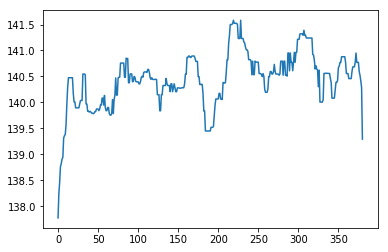

In [2]:
x,fs = sf.read('my_a.wav')
f0, t = pw.dio(x, fs)
f0 = scipy.signal.medfilt(f0[10:-10],11)
plt.plot(f0)
print(int(np.mean(f0)/(44100/8192))-5)

dist A,B 75 74


C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


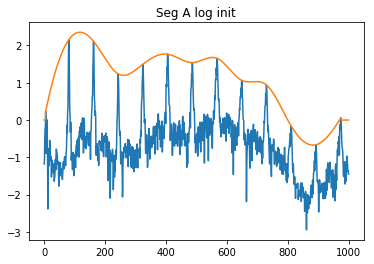

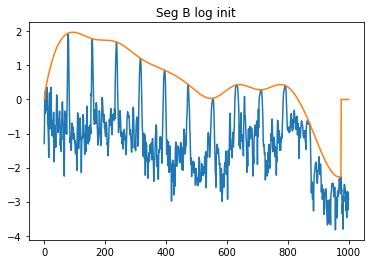

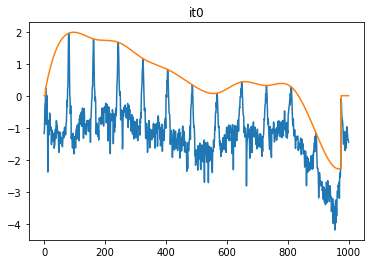

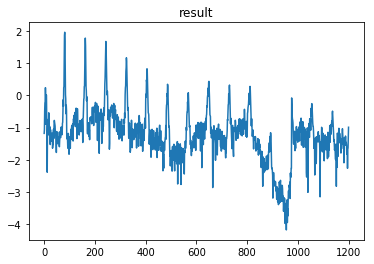

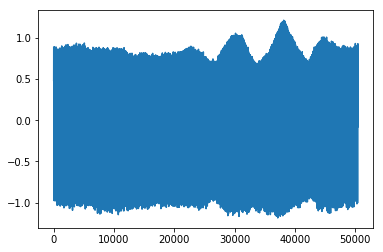

In [45]:
# input : 
# timbre_src(string) input file name
# vowel_src(string) input file name

import scipy.io as sio
DEBUG = True
which_seg = 12

def IFF(timbre_src,vowel_src,it= 2):
    T,fs = sf.read(timbre_src)
    V,fs = sf.read(vowel_src)
    
    absA,phaA = getAmpPha(T)
    absB,_ = getAmpPha(V)

    seg_A = cp.copy(absA[:freq_range,which_seg])
    seg_B = cp.copy(absB[:freq_range,which_seg])
    
    seg_B_log = np.log10(seg_B)
    
    
    seg_A_log = np.log10(seg_A)

    f0T,_ = pw.dio(T, fs)
    f0T = scipy.signal.medfilt(f0T[10:-10],11)
    distA = int(np.mean(f0T)/(fs/_NFFT_))-5
    
    f0V,_ = pw.dio(V, fs)
    f0V = scipy.signal.medfilt(f0V[10:-10],11)
    distB = int(np.mean(f0V)/(fs/_NFFT_))-5
    
    peaks_A,peaks_B = get_peak_idx(seg_A_log,seg_B_log,distA,distB)
    print('dist A,B',distA,distB)
    
    
    curve_,c1,c2 = getCurveLog(seg_A_log,seg_B_log,peaks_A,peaks_B)
    seg_A *=curve_

    
    if DEBUG:
        plt.title('Seg A log init')
        plt.plot(seg_A_log)
        plt.plot(c1)
        plt.show()
#         sio.savemat('./tmp/A_log.mat', {'A_log':seg_A_log.flatten()})
#         sio.savemat('./tmp/A_env.mat', {'A_env':c1.flatten()})
        
        plt.title('Seg B log init')
        plt.plot(seg_B_log)
        plt.plot(c2)
        
        plt.show()   
        
    for i in range(it):
        seg_A_log = np.log10(seg_A)
        curve_tmp,c1,_ = getCurveLog(seg_A_log,seg_B_log,peaks_A,peaks_B)
        curve_ *= curve_tmp
        seg_A *=curve_tmp
        
        if DEBUG:
            plt.title('it'+str(i))
            plt.plot(seg_A_log)
            plt.plot(c1)
            plt.show()   

    curve = np.ones((int(_NFFT_/2)+1,))
    curve[:freq_range] = curve_

    out = modify_specEnv(absA,curve)
    
    if DEBUG:
        plt.title('result')
        plt.plot(np.log10(out[:freq_range+200,which_seg]))
        plt.show()
    
    xx = librosa.istft(out*phaA,hop_length=HOP_LEN)
    xx = xx/(max(xx)-min(xx))*0.4
    return xx

# xx = IFF('my_a.wav','e_01.wav',4)
# xx = IFF('e_nagoya.wav','my_a.wav',3)
# xx = IFF('e_nagoya.wav','my_a_410.wav',3)

xx = IFF('e_nagoya.wav','iton_a.wav',1)

# xx = IFF('e_nagoya.wav','a_nagoya.wav',2)


seg = xx[1000:-1000]*6
plt.plot(seg)
sf.write('test.wav',seg,fs)
ipd.Audio(seg, rate=fs)

In [9]:
V,fs = sf.read('e_nagoya.wav')    
# V,fs = sf.read('iton_a.wav')    
ipd.Audio(V, rate=fs)

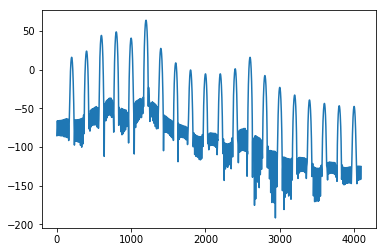

In [10]:
spec = sio.loadmat('./tmp/A_spec')['dbsspecn']
plt.plot(spec)

C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


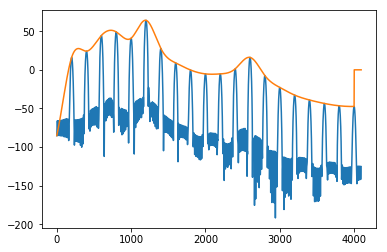

In [22]:
peaks_A, _ = find_peaks(spec.flatten(), distance=150)
peaks_A = np.concatenate(([0],peaks_A))
c1 = scipy.interpolate.spline(peaks_A,spec[peaks_A],range(4096))
plt.plot(spec)
plt.plot(c1)
sio.savemat('./tmp/my_env.mat', {'my_env':c1})

In [18]:
A = 'e_nagoya.wav'
B = 'a_nagoya.wav'

VA,fs = sf.read(A)
VB,fs = sf.read(B)
# ipd.Audio(VA, rate=fs)
ipd.Audio(VB, rate=fs)


In [174]:
T,fs = sf.read('e_01.wav')
ipd.Audio(T, rate=fs)

In [147]:
x,fs = sf.read('my_o.wav')
y,fs = sf.read('test.wav')
x = x[:80000]
y = y[:80000]
xAmp,xPha = getAmpPha(x)
yAmp,yPha = getAmpPha(y)

xx = librosa.istft(yAmp*xPha,hop_length=HOP_LEN)
xx = xx/(max(xx)-min(xx))*0.4
ipd.Audio(xx, rate=fs)


In [130]:

ipd.Audio(y, rate=fs)
